# HealthAI - Multiclass Risk Stratification

This notebook loads CSVs from the current folder (no ZIPs/subfolders),
builds a **multiclass** label from ICD codes (0=other, 1=diabetes, 2=hypertension, 3=CKD),
engineers features (labs, Rx, EMAR, demographics), and trains **Logistic Regression (multinomial)**,
**XGBoost (multi:softprob)**, and **MLP** with robust metrics.


In [ ]:
import os, re, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

from functools import reduce
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix
)
from scipy.stats import loguniform
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import BaseEstimator, TransformerMixin

# imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
plt.rcParams["figure.figsize"] = (8,5)

# -----------------------------
# Helpers
# -----------------------------
def find_one_any(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def read_csv_auto(path, **kw):
    if path is None:
        return None
    return pd.read_csv(path, low_memory=False, **kw)

def _coerce_int64_nullable(df, cols):
    if df is None:
        return df
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
    return df

def _dedup_on(df, key):
    if df is None or key not in df.columns:
        return df
    return df.drop_duplicates(subset=[key]).copy()

def _norm_icd_version(series):
    s = pd.Series(series).astype(str).str.extract(r'(\d+)', expand=False)
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def compute_age_at_admit(admittime, anchor_year, anchor_age):
    y = pd.to_datetime(admittime).dt.year
    return (anchor_age + (y - anchor_year)).clip(lower=0)

def collapse_duplicate_columns(df_in):
    cols = pd.Index(df_in.columns)
    if not cols.has_duplicates:
        return df_in
    out = {}
    for col in cols.unique():
        sub = df_in.loc[:, df_in.columns == col]
        out[col] = sub.iloc[:, 0] if sub.shape[1] == 1 else sub.mean(axis=1, skipna=True)
    newdf = pd.DataFrame(out, index=df_in.index)
    ordered = [c for c in ["hadm_id","subject_id"] if c in newdf.columns]
    ordered += [c for c in newdf.columns if c not in ordered]
    return newdf[ordered]

def plot_class_dist(y, title):
    vc = y.value_counts().sort_index()
    ax = vc.plot(kind="bar")
    plt.title(title); plt.xlabel("Class label"); plt.ylabel("Count")
    for i, v in enumerate(vc.values):
        ax.text(i, v, str(int(v)), ha="center", va="bottom", fontsize=9)
    plt.tight_layout(); plt.show()

# picklable categorical-to-string transformer (replaces lambda FunctionTransformer)
class ToStr(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.fillna("NA").astype(str).to_numpy()
        return pd.DataFrame(X).fillna("NA").astype(str).to_numpy()

# Optional cost emphasis per class
COST_WEIGHTS = { }   # e.g., {2: 2.0}

def make_models(n_classes, is_multiclass):
    if is_multiclass:
        return {
            "LogReg": LogisticRegression(
                max_iter=3000, class_weight=None,
                multi_class="multinomial", solver="lbfgs"
            ),
            "XGB": XGBClassifier(
                n_estimators=500, max_depth=6, learning_rate=0.05,
                subsample=0.85, colsample_bytree=0.85, tree_method="hist",
                objective="multi:softprob", num_class=n_classes,
                eval_metric="mlogloss", random_state=42
            ),
            "MLP": MLPClassifier(
                hidden_layer_sizes=(512,128),
                max_iter=250, learning_rate_init=5e-4, random_state=42
            )
        }
    else:
        return {
            "LogReg": LogisticRegression(max_iter=3000, class_weight="balanced"),
            "XGB": XGBClassifier(
                n_estimators=500, max_depth=6, learning_rate=0.05,
                subsample=0.85, colsample_bytree=0.85, tree_method="hist",
                eval_metric="logloss", random_state=42
            ),
            "MLP": MLPClassifier(
                hidden_layer_sizes=(512,128),
                max_iter=200, learning_rate_init=5e-4, random_state=42
            )
        }

In [3]:
# -----------------------------------------------------------------------
# Project-wide dataset base (Windows path provided by user)
# -----------------------------------------------------------------------
import glob
DATA_BASE = r"D:/HealthAI Project/data"

def _glob_rel(rel_pattern):
    pat = os.path.join(DATA_BASE, "**", rel_pattern)
    return glob.glob(pat, recursive=True)

def _ci_filename_search(basenames):
    hits = []
    for root, _, files in os.walk(DATA_BASE):
        lowfiles = [f.lower() for f in files]
        for name in basenames:
            name_low = name.lower()
            for i,f in enumerate(lowfiles):
                if f == name_low:
                    hits.append(os.path.join(root, files[i]))
    return hits

def find_one_any(rel_candidates, must=False, friendly=""):
    for rel in rel_candidates:
        hits = _glob_rel(rel)
        if hits:
            print("[found] %s -> %s" % (rel, hits[0]))
            return hits[0]
    basenames = [os.path.basename(r) for r in rel_candidates]
    ci_hits = _ci_filename_search(basenames)
    if ci_hits:
        print("[found-ci] one of %s -> %s" % (basenames, ci_hits[0]))
        return ci_hits[0]
    if must:
        msg = "Could not find: %s under DATA_BASE=%s. Tried candidates=%s" % (friendly or str(rel_candidates), DATA_BASE, rel_candidates)
        raise FileNotFoundError(msg)
    return None

def read_csv_auto(path):
    comp = "gzip" if str(path).lower().endswith(".gz") else None
    return pd.read_csv(path, compression=comp, low_memory=False)

print("Using DATA_BASE:", DATA_BASE)

Using DATA_BASE: D:/HealthAI Project/data


In [4]:
# -----------------------------
# Discover CSVs
# -----------------------------
pat_p  = find_one_any(["patients.csv"])
adm_p  = find_one_any(["admissions_clean.csv"])
dx_p   = find_one_any(["diagnoses_icd.csv"])
dxd_p  = find_one_any(["d_icd_diagnoses.csv"])
dlab_p = find_one_any(["d_labitems.csv"])
labs_p = find_one_any(["labevents.csv"])
rx_p   = find_one_any(["prescriptions.csv"])
em_p   = find_one_any(["emar.csv"])

# extra sources (optional)
vitals_p = find_one_any(["vitalsign.csv"])

print('Found files:')
for k,v in {"patients":pat_p,"admissions_clean":adm_p,"diagnoses_icd":dx_p,"d_icd_diagnoses":dxd_p,
            "d_labitems":dlab_p,"labevents":labs_p,"prescriptions":rx_p,"emar":em_p,
            "vitals":vitals_p}.items():
    print(f"  {k:16s} -> {v}")

if adm_p is None:
    raise FileNotFoundError("admissions_clean CSV not found (admissions_clean.csv).")

# -----------------------------
# Load + base
# -----------------------------
pat = read_csv_auto(pat_p)
adm = read_csv_auto(adm_p)

for c in ["admittime","dischtime"]:
    if c in adm.columns:
        adm[c] = pd.to_datetime(adm[c], errors="coerce")
if {"admittime","dischtime"}.issubset(adm.columns):
    adm["los_days"] = (adm["dischtime"] - adm["admittime"]).dt.total_seconds()/86400.0

keep_cols = [c for c in ["subject_id","hadm_id","admittime","dischtime","insurance","language","los_days"] if c in adm.columns]
adm = adm[keep_cols]

if pat is not None:
    if "sex" not in pat.columns and "gender" in pat.columns:
        pat = pat.rename(columns={"gender":"sex"})

if pat is not None and {"subject_id","anchor_year","anchor_age","sex"}.issubset(pat.columns):
    base = adm.merge(pat[["subject_id","anchor_year","anchor_age","sex"]], on="subject_id", how="left")
else:
    base = adm.copy()

if {"admittime","anchor_year","anchor_age"}.issubset(base.columns):
    base["age_at_admit"] = compute_age_at_admit(base["admittime"], base["anchor_year"], base["anchor_age"])

# -----------------------------
# Labs — expanded set
# -----------------------------
wide = None
if dlab_p and labs_p:
    dlab = read_csv_auto(dlab_p)
    labs = read_csv_auto(labs_p)
    if dlab is not None and labs is not None and {"itemid","label"}.issubset(dlab.columns):
        dlab["label_l"] = dlab["label"].astype(str).str.lower()
        keep = dlab[dlab["label_l"].str.contains(
            "glucose|creatinine|hemoglobin|hematocrit|platelet|wbc|white blood|albumin|bilirubin|lactate|bun|urea|sodium|potassium|chloride|bicarbonate|na\\b|k\\b|cl\\b|hco3",
            regex=True, na=False)]
        if {"hadm_id","itemid","valuenum"}.issubset(labs.columns):
            labs = labs[["hadm_id","itemid","valuenum"]].dropna()
            labs = labs[labs["itemid"].isin(keep["itemid"])]
            ag = labs.groupby(["hadm_id","itemid"])["valuenum"].mean().reset_index()
            label_map = dict(zip(keep["itemid"], keep["label"].str.lower().str.replace(r"\s+","_", regex=True)))
            wide = ag.pivot(index="hadm_id", columns="itemid", values="valuenum").rename_axis(None, axis=1).reset_index()
            wide.columns = ["hadm_id"] + [f"lab_{label_map.get(c,str(c))}_mean" for c in wide.columns[1:]]

# -----------------------------
# Vitals (optional; robust to different column names)
# -----------------------------
vitalsw = None
if vitals_p:
    vit = read_csv_auto(vitals_p)
    if vit is not None and "hadm_id" in vit.columns:
        rename_map = {
            "hr":"heart_rate","heartrate":"heart_rate","heart rate":"heart_rate",
            "sbp":"sbp","systolic_bp":"sbp","systolic blood pressure":"sbp",
            "dbp":"dbp","diastolic_bp":"dbp","diastolic blood pressure":"dbp",
            "map":"map","mean arterial pressure":"map",
            "rr":"resp_rate","respiratory_rate":"resp_rate","resp rate":"resp_rate",
            "temp":"temperature","temperature c":"temperature","temperature_f":"temperature",
            "spo2":"spo2","o2sat":"spo2","oxygen_saturation":"spo2"
        }
        lowcols = {c: c.lower() for c in vit.columns}
        vit = vit.rename(columns={orig: rename_map.get(low, low) for orig, low in lowcols.items()})
        keep_v = [c for c in ["heart_rate","sbp","dbp","map","resp_rate","temperature","spo2"] if c in vit.columns]
        cols = ["hadm_id"] + keep_v
        vit = vit[cols].copy()
        vit_agg = vit.groupby("hadm_id")[keep_v].mean().reset_index()
        vit_agg.columns = ["hadm_id"] + [f"vital_{c}_mean" for c in keep_v]
        vitalsw = vit_agg

# -----------------------------
# Rx wide
# -----------------------------
rxw = None
rx_p = rx_p
if rx_p:
    rx = read_csv_auto(rx_p)
    if rx is not None:
        cols = [c for c in ["hadm_id","drug","gsn"] if c in rx.columns]
        rx = rx[cols]
        rx["drug"] = rx["drug"].astype(str)
        if "gsn" in rx.columns:
            rx["gsn"] = rx["gsn"].astype(str)
        rxf = rx.groupby("hadm_id").agg(rx_count=("drug","count"), rx_unique=("drug","nunique")).reset_index()
        keys={"rx_insulin":["insulin"], "rx_metformin":["metformin"],
              "rx_statin":["atorvastatin","rosuvastatin","simvastatin","pravastatin","lovastatin"]}
        rows2=[]
        for hadm,g in rx.groupby("hadm_id"):
            text=(" ".join(g["drug"])+" "+ " ".join(g["gsn"] if "gsn" in g.columns else [])).lower()
            rows2.append({"hadm_id":hadm, **{k:int(any(kw in text for kw in kws)) for k,kws in keys.items()}})
        rxw = pd.merge(rxf, pd.DataFrame(rows2), on="hadm_id", how="left").fillna(0)

# -----------------------------
# EMAR wide
# -----------------------------
emw = None
if em_p:
    em = read_csv_auto(em_p)
    if em is not None and {"hadm_id","medication"}.issubset(em.columns):
        em = em[["hadm_id","medication"]]
        em["medication"]=em["medication"].astype(str).str.lower()
        emf = em.groupby("hadm_id").agg(emar_admin_count=("medication","count")).reset_index()
        emi = em.groupby("hadm_id")["medication"].apply(lambda s: int(any("insulin" in x for x in s))).reset_index(name="emar_insulin")
        emw = emf.merge(emi, on="hadm_id", how="left").fillna(0)

[found] patients.csv -> D:/HealthAI Project/data\MIMIC IV\patients.csv
[found] admissions_clean.csv -> D:/HealthAI Project/data\MIMIC IV\admissions_clean.csv
[found] diagnoses_icd.csv -> D:/HealthAI Project/data\MIMIC IV\diagnoses_icd.csv
[found] d_icd_diagnoses.csv -> D:/HealthAI Project/data\MIMIC IV\d_icd_diagnoses.csv
[found] d_labitems.csv -> D:/HealthAI Project/data\MIMIC IV\d_labitems.csv
[found] labevents.csv -> D:/HealthAI Project/data\MIMIC IV\labevents.csv
[found] prescriptions.csv -> D:/HealthAI Project/data\MIMIC IV\prescriptions.csv
[found] emar.csv -> D:/HealthAI Project/data\MIMIC IV\emar.csv
[found] vitalsign.csv -> D:/HealthAI Project/data\MIMIC IV\vitalsign.csv
Found files:
  patients         -> D:/HealthAI Project/data\MIMIC IV\patients.csv
  admissions_clean -> D:/HealthAI Project/data\MIMIC IV\admissions_clean.csv
  diagnoses_icd    -> D:/HealthAI Project/data\MIMIC IV\diagnoses_icd.csv
  d_icd_diagnoses  -> D:/HealthAI Project/data\MIMIC IV\d_icd_diagnoses.csv
  

In [5]:
# -----------------------------
# ICD merge -> labels + diag groups
# 0 = other, 1 = diabetes, 2 = hypertension, 3 = CKD
# -----------------------------
labels_multi = None
diag_groups = None
if dx_p and dxd_p:
    d     = read_csv_auto(dx_p)
    dictd = read_csv_auto(dxd_p)
    if d is not None and dictd is not None and {"icd_code","icd_version"}.issubset(d.columns) and {"icd_code","icd_version"}.issubset(dictd.columns):
        for _df in (d, dictd):
            _df["icd_code"] = _df["icd_code"].astype(str).str.strip().str.upper()
            _df["icd_version"] = _norm_icd_version(_df["icd_version"])
        dx = d.merge(dictd, on=["icd_code","icd_version"], how="left")
        rows = []
        for hadm, g in dx.groupby("hadm_id"):
            c10 = g.loc[g["icd_version"].eq(10), "icd_code"].astype(str).tolist()
            c9  = g.loc[g["icd_version"].eq(9),  "icd_code"].astype(str).tolist()
            has_diab = any(c.startswith(("E10","E11","E12","E13","E14")) for c in c10) or any(c.startswith("250") for c in c9)
            has_htn  = any(c.startswith(("I10","I11","I12","I13","I15")) for c in c10) or any(re.match(r"40[1-5]", c) for c in c9)
            has_ckd  = any(c.startswith("N18") for c in c10) or any(c.startswith("585") for c in c9)
            if has_diab: label = 1
            elif has_htn: label = 2
            elif has_ckd: label = 3
            else: label = 0
            rows.append({"hadm_id": hadm, "label_disease": label})
        labels_multi = pd.DataFrame(rows)
        feats=[]
        for hadm, g in dx.groupby("hadm_id"):
            c10 = g.loc[g["icd_version"].eq(10), "icd_code"].astype(str).tolist()
            c9  = g.loc[g["icd_version"].eq(9),  "icd_code"].astype(str).tolist()
            f = {
                "hadm_id": hadm,
                "dx10_E_count": sum(x.startswith("E") for x in c10),
                "dx10_I_count": sum(x.startswith("I") for x in c10),
                "dx10_N_count": sum(x.startswith("N") for x in c10),
                "dx10_J_count": sum(x.startswith("J") for x in c10),
                "dx9_250_count": sum(x.startswith("250") for x in c9),
                "dx9_401_405_count": sum(re.match(r"40[1-5]", x) is not None for x in c9),
                "dx10_N18_count": sum(x.startswith("N18") for x in c10)
            }
            feats.append(f)
        diag_groups = pd.DataFrame(feats)

print("labels_multi built:", labels_multi is not None)

labels_multi built: True


In [6]:
# -----------------------------
# Merge all & DROP label==3
# -----------------------------
frames = {"base":base, "wide":wide, "vitals":vitalsw, "rxw":rxw, "emw":emw, "labels":labels_multi, "diag_groups":diag_groups}
for k in frames:
    frames[k] = _coerce_int64_nullable(frames[k], ["hadm_id","subject_id"])
    frames[k] = _dedup_on(frames[k], "hadm_id")

if base is None:
    raise RuntimeError("Base admissions/patients merge not available. Ensure admissions and patients CSVs are present.")

to_merge = [frames[x] for x in ["labels","wide","vitals","rxw","emw","diag_groups"] if frames[x] is not None]
df = reduce(lambda left, right: left.merge(right, on="hadm_id", how="left"), [frames["base"]] + to_merge)
df = df.fillna(0)

if "label_disease" not in df.columns:
    raise RuntimeError("label_disease missing after merge.")
before = len(df)
df = df[df["label_disease"].astype(float) != 3.0].copy()
df["label_disease"] = df["label_disease"].astype(int)
after = len(df)
print(f"Dropped label==3 rows: {before - after} (remaining: {after})")

print("Merged df shape:", df.shape)
try: display(df.head())
except: print(df.head())

Dropped label==3 rows: 6173 (remaining: 539679)
Merged df shape: (539679, 133)


,subject_id,hadm_id,admittime,dischtime,insurance,language,los_days,anchor_year,anchor_age,sex,age_at_admit,label_disease,"lab_calculated_bicarbonate,_whole_blood_mean",lab_carboxyhemoglobin_mean,"lab_chloride,_whole_blood_mean",lab_glucose_mean,"lab_hematocrit,_calculated_mean",lab_hemoglobin_mean,lab_lactate_mean,lab_methemoglobin_mean,"lab_potassium,_whole_blood_mean","lab_sodium,_whole_blood_mean","lab_albumin,_ascites_mean","lab_bicarbonate,_ascites_mean","lab_bilirubin,_total,_ascites_mean","lab_chloride,_ascites_mean","lab_creatinine,_ascites_mean","lab_glucose,_ascites_mean","lab_lactate_dehydrogenase,_ascites_mean","lab_potassium,_ascites_mean","lab_sodium,_ascites_mean","lab_urea_nitrogen,_ascites_mean",lab_%_hemoglobin_a1c_mean,lab_albumin_mean,lab_bicarbonate_mean,"lab_bilirubin,_direct_mean","lab_bilirubin,_indirect_mean","lab_bilirubin,_total_mean",lab_chloride_mean,lab_ck-mb_index_mean,lab_creatine_kinase_(ck)_mean,lab_creatinine_mean,lab_glucose_mean,lab_lactate_dehydrogenase_(ld)_mean,lab_potassium_mean,lab_sodium_mean,lab_tacrofk_mean,lab_urea_nitrogen_mean,"lab_albumin,_joint_fluid_mean","lab_creatinine,_joint_fluid_mean","lab_glucose,_joint_fluid_mean","lab_albumin,_body_fluid_mean","lab_bicarbonate,_other_fluid_mean","lab_bilirubin,_total,_body_fluid_mean","lab_chloride,_body_fluid_mean","lab_creatinine,_body_fluid_mean","lab_glucose,_body_fluid_mean","lab_potassium,_body_fluid_mean","lab_sodium,_body_fluid_mean","lab_urea_nitrogen,_body_fluid_mean",...,lab_24_hr_creatinine_mean,"lab_albumin,_urine_mean","lab_albumin/creatinine,_urine_mean","lab_amylase/creatinine_ratio,_urine_mean","lab_bicarbonate,_urine_mean","lab_chloride,_urine_mean",lab_creatinine_clearance_mean,"lab_creatinine,_serum_mean","lab_creatinine,_urine_mean","lab_glucose,_urine_mean","lab_potassium,_urine_mean",lab_protein/creatinine_ratio_mean,"lab_sodium,_urine_mean","lab_urea_nitrogen,_urine_mean",lab_urine_creatinine_mean,"lab_hematocrit,_ascites_mean",lab_fetal_hemoglobin_mean,lab_hematocrit_mean,lab_hemoglobin_mean,lab_hemoglobin_a2_mean,lab_hemoglobin_c_mean,lab_hemoglobin_f_mean,lab_large_platelets_mean,lab_platelet_count_mean,lab_platelet_smear_mean,lab_wbc_count_mean,lab_white_blood_cells_mean,"lab_hematocrit,_joint_fluid_mean","lab_hematocrit,_other_fluid_mean","lab_hematocrit,_pleural_mean",lab_glucose_mean,lab_hematocrit_mean,lab_wbc_mean,lab_wbc_casts_mean,lab_epstein-barr_virus_ebna_igg_ab_mean,lab_k_(green)_mean,lab_<albumin>_mean,"lab_bilirubin,_total,_csf_mean","lab_glucose,_csf_mean","lab_lactate_dehydrogenase,_csf_mean",lab_surfactant/albumin_mean,"lab_urea_nitrogen,_pleural_mean","lab_creatinine,_whole_blood_mean",lab_hemoglobin_other_mean,lab_wbcp_mean,"lab_hematocrit,_csf_mean",rx_count,rx_unique,rx_insulin,rx_metformin,rx_statin,emar_admin_count,emar_insulin,dx10_E_count,dx10_I_count,dx10_N_count,dx10_J_count,dx9_250_count,dx9_401_405_count,dx10_N18_count
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,MEDICAID,English,0.786111,2180,52,F,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,1.3,105.000000,0.0,0.0,0.300000,99.000000,0.0,4.500000,137.000000,0.0,25.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.60,12.70,0.0,0.0,0.0,0.0,71.0,0.0,0.0,4.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,12.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,MEDICAID,English,1.015278,2180,52,F,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.7,25.0,0.0,0.0,1.2,92.000000,0.0,0.0,0.300000,71.000000,0.0,5.200000,126.000000,0.0,29.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.50,12.40,0.0,0.0,0.0,0.0,137.0,0.0,0.0,6.60,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [7]:
# -----------------------------
# Subject-wise split
# -----------------------------
subs = df["subject_id"].dropna().unique()
if len(subs) < 2:
    raise RuntimeError("Not enough distinct subject_id values for a subject-wise split.")

rng = np.random.default_rng(42)
test_subs = set(rng.choice(subs, size=max(1, int(0.2*len(subs))), replace=False))
train = df[~df["subject_id"].isin(test_subs)].copy()
test  = df[df["subject_id"].isin(test_subs)].copy()

target = "label_disease"
y_tr, y_te = train[target].astype(int), test[target].astype(int)
drop_cols = [c for c in ["subject_id","hadm_id","admittime","dischtime","anchor_year","anchor_age",target] if c in train.columns]
X_tr = train.drop(columns=drop_cols, errors="ignore")
X_te = test.drop(columns=drop_cols, errors="ignore")

# collapse duplicates from wide pivots
X_tr = collapse_duplicate_columns(X_tr)
X_te = collapse_duplicate_columns(X_te)
X_tr = X_tr.loc[:, ~X_tr.columns.duplicated()]
X_te = X_te.loc[:, ~X_te.columns.duplicated()]

In [8]:
# -----------------------------
# Preprocessor (dense) for SMOTE and picklable (no lambdas)
# -----------------------------
num = pd.Index(X_tr.select_dtypes(include=np.number).columns).drop_duplicates()
cat = pd.Index(X_tr.select_dtypes(exclude=np.number).columns).drop_duplicates()
num = [c for c in num if c not in ("hadm_id","subject_id")]
cat = [c for c in cat if c not in ("hadm_id","subject_id")]

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # use sparse=False for broad sklearn compatibility

transformers = []
if len(num) > 0:
    transformers.append(("num", StandardScaler(), num))
if len(cat) > 0:
    transformers.append((
        "cat",
        Pipeline([
            ("to_str", ToStr()),  # picklable replacement for lambda FunctionTransformer
            ("ohe", ohe)
        ]),
        cat
    ))
if len(transformers) == 0:
    raise RuntimeError("No usable features left after preprocessing. Check your inputs.")
pre = ColumnTransformer(transformers)

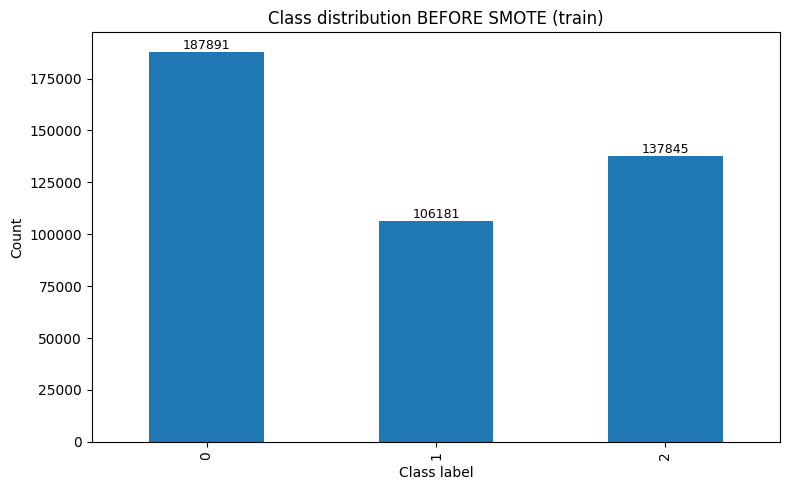

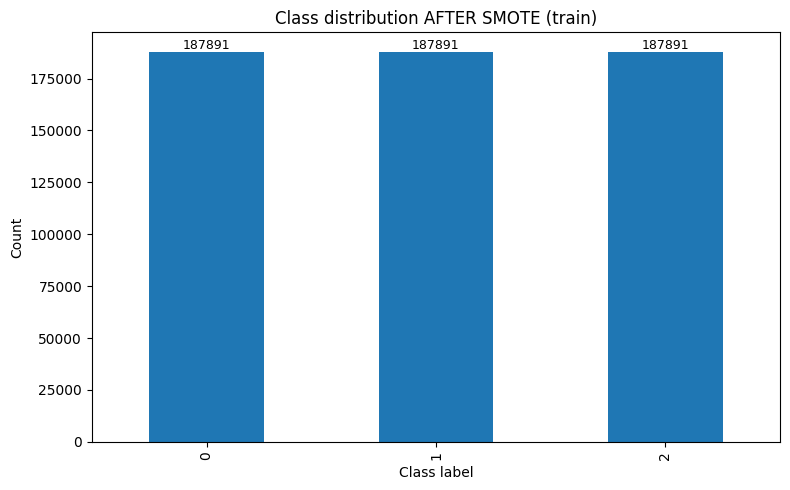

In [9]:
# -----------------------------
# Show class imbalance BEFORE/AFTER SMOTE (for plotting only)
# -----------------------------
plot_class_dist(y_tr, "Class distribution BEFORE SMOTE (train)")

# Fit preprocessor once for plotting & run SMOTE to visualize after-dist
Xtr_enc = pre.fit_transform(X_tr)
smote_vis = SMOTE(k_neighbors=5, random_state=42)
_, y_tr_sm_vis = smote_vis.fit_resample(Xtr_enc, y_tr)
plot_class_dist(pd.Series(y_tr_sm_vis), "Class distribution AFTER SMOTE (train)")

In [10]:
# =============================
# Models & training
# =============================
classes = np.unique(y_tr)  # use training classes
n_classes = len(classes)
if n_classes < 2:
    raise RuntimeError(f"Need at least two classes after dropping label 3; got classes={classes}.")
is_multiclass = n_classes > 2
models = make_models(n_classes, is_multiclass)

results = []
for name, clf in models.items():
    pipe = Pipeline([("pre", pre), ("clf", clf)]).fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    avg = "weighted" if is_multiclass else "binary"
    acc = accuracy_score(y_te, y_pred)
    f1  = f1_score(y_te, y_pred, average=avg, zero_division=0)
    pre_s = precision_score(y_te, y_pred, average=avg, zero_division=0)
    rec = recall_score(y_te, y_pred, average=avg, zero_division=0)

    roc = None
    if hasattr(pipe, "predict_proba"):
        proba = pipe.predict_proba(X_te)
        if is_multiclass:
            roc = roc_auc_score(y_te, proba, multi_class="ovr", average="weighted")
        else:
            roc = roc_auc_score(y_te, proba[:, 1])
    elif hasattr(pipe, "decision_function"):
        score = pipe.decision_function(X_te)
        if is_multiclass and getattr(score, "ndim", 1) > 1:
            roc = roc_auc_score(y_te, score, multi_class="ovr", average="weighted")
        else:
            roc = roc_auc_score(y_te, score)

    print(f"\n=== {name} ===")
    print(classification_report(y_te, y_pred, zero_division=0))
    print(f"Accuracy: {acc:.3f}")
    print(f"F1 ({avg}): {f1:.3f}")
    print(f"Precision ({avg}): {pre_s:.3f}")
    print(f"Recall ({avg}): {rec:.3f}")
    if roc is not None:
        print(f"ROC-AUC (OVR if multiclass): {roc:.3f}")

    # Confusion Matrix (counts) via Plotly
    cm = confusion_matrix(y_te, y_pred, labels=classes)
    fig = px.imshow(
        cm,
        x=[str(c) for c in classes],   # predicted
        y=[str(c) for c in classes],   # true
        text_auto=True,
        aspect="equal",
        title=f"Confusion Matrix (counts) — {name}",
    )
    fig.update_layout(xaxis_title="Predicted label", yaxis_title="True label", coloraxis_showscale=True)
    fig.update_xaxes(side="top")
    fig.show()

    results.append({"model": name, "accuracy": acc, "f1": f1, "precision": pre_s, "recall": rec, "roc_auc": roc})

results_df = pd.DataFrame(results).sort_values(by=["f1","accuracy"], ascending=False)
print("\n=== Model Comparison ===")
try:
    display(results_df)
except NameError:
    print(results_df)


=== LogReg ===
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     46835
           1       0.93      0.91      0.92     26665
           2       0.89      0.82      0.85     34262

    accuracy                           0.90    107762
   macro avg       0.90      0.89      0.90    107762
weighted avg       0.90      0.90      0.90    107762

Accuracy: 0.898
F1 (weighted): 0.898
Precision (weighted): 0.898
Recall (weighted): 0.898
ROC-AUC (OVR if multiclass): 0.983



=== XGB ===
              precision    recall  f1-score   support

           0       0.97      0.92      0.95     46835
           1       0.94      0.92      0.93     26665
           2       0.86      0.94      0.90     34262

    accuracy                           0.93    107762
   macro avg       0.93      0.93      0.93    107762
weighted avg       0.93      0.93      0.93    107762

Accuracy: 0.928
F1 (weighted): 0.929
Precision (weighted): 0.931
Recall (weighted): 0.928
ROC-AUC (OVR if multiclass): 0.990



=== MLP ===
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     46835
           1       0.91      0.91      0.91     26665
           2       0.86      0.87      0.86     34262

    accuracy                           0.90    107762
   macro avg       0.90      0.90      0.90    107762
weighted avg       0.90      0.90      0.90    107762

Accuracy: 0.902
F1 (weighted): 0.902
Precision (weighted): 0.903
Recall (weighted): 0.902
ROC-AUC (OVR if multiclass): 0.982



=== Model Comparison ===


,model,accuracy,f1,precision,recall,roc_auc
1,XGB,0.928110,0.928746,0.931361,0.928110,0.990276
2,MLP,0.902294,0.902437,0.902631,0.902294,0.982426
0,LogReg,0.898239,0.897514,0.898399,0.898239,0.983478


In [ ]:
# -----------------------------
# Save best-by-F1 model (picklable) -> Models/
# -----------------------------
best_row  = results_df.iloc[0]
best_name = str(best_row["model"])
print(f"\nBest model by F1 score: {best_name} (F1={best_row['f1']:.3f})")

best_clf  = models[best_name]
best_pipe = Pipeline([("pre", pre), ("clf", best_clf)]).fit(X_tr, y_tr)

models_dir = "Models/Classification_Model"
os.makedirs(models_dir, exist_ok=True)
pkl_path = os.path.join(models_dir, f"best_model_{best_name}.pkl")

with open(pkl_path, "wb") as f:
    pickle.dump(best_pipe, f)

print(f"Saved best model pipeline to: {pkl_path}")


Best model by F1 score: XGB (F1=0.929)
Saved best model pipeline to: Models\best_model_XGB.pkl


In [ ]:
# 1) Choose a sensible column order for readability
first_cols = [c for c in ["subject_id", "hadm_id", "admittime", "dischtime",
                          "los_days", "sex", "age_at_admit", "insurance", "language",
                          "label_disease"] if c in df.columns]
other_cols = [c for c in df.columns if c not in first_cols]
df_ordered = df[first_cols + other_cols]

# 2) Create an output folder
OUT_DIR = os.path.join(DATA_BASE, "Merged")
os.makedirs(OUT_DIR, exist_ok=True)

# 3) Save the fully merged dataset (one CSV containing all required inputs merged as one)
merged_path = os.path.join(OUT_DIR, "classification_test_data.csv")
df_ordered.to_csv(merged_path, index=False)
print(f"[saved] merged dataset -> {merged_path}  (rows={len(df_ordered)}, cols={df_ordered.shape[1]})")

[saved] merged dataset -> D:/HealthAI Project/data\Merged\healthai_merged_dataset.csv  (rows=539679, cols=143)
